In [ ]:
!pip install nltk contractions emoji pyspellchecker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from bs4 import BeautifulSoup
import contractions
import emoji
from spellchecker import SpellChecker

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/labeled_final_test.csv")
df.head(10)

,id,sentence1,sentence2,label
0,1,This was a series of nested angular standards ...,"This was a series of nested polar scales , so ...",0
1,2,His father emigrated to Missouri in 1868 but r...,"His father emigrated to America in 1868 , but ...",0
2,3,"In January 2011 , the Deputy Secretary General...","In January 2011 , FIBA Asia deputy secretary g...",1
3,4,"Steiner argued that , in the right circumstanc...",Steiner held that the spiritual world can be r...,0
4,5,"Luciano Williames Dias ( born July 25 , 1970 )...",Luciano Williames Dias ( born 25 July 1970 ) i...,0
5,6,"During her sophomore , junior and senior summe...","During her second , junior and senior summers ...",1
6,7,The smallest number that can be represented in...,The smallest number that can be represented as...,0
7,8,"His father emigrated to Missouri in 1868 , but...",His father emigrated to Missouri in 1868 but r...,1
8,9,The Villa Pesquera facilities are owned by the...,The facilities of Villa Pesquera are operated ...,0
9,10,It is situated south of Köroğlu Mountains and ...,It is situated south of Köroğlu - mountains an...,1


In [ ]:
# Download NLTK data (only needs to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    words = text.split()

    # Initialize lemmatizer and stemmer
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    # Remove stopwords, apply lemmatization and stemming
    processed_words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words if word not in stopwords.words('english')]

    return ' '.join(processed_words)

In [ ]:
# Clean both sentences before splitting
df['sentence1'] = df['sentence1'].apply(preprocess_text)
df['sentence2'] = df['sentence2'].apply(preprocess_text)

In [ ]:
import spacy

# Load spaCy English model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
def tag_text_with_ner_pos(text):
    doc = nlp(text)
    tagged_tokens = []
    for token in doc:
        word = token.text.lower()
        pos = token.pos_  # e.g., NOUN, VERB
        ner = token.ent_type_ if token.ent_type_ else "O"  # e.g., PERSON, ORG, etc., or O = no entity
        tagged_token = f"{ner}_{pos}_{word}"
        tagged_tokens.append(tagged_token)
    return " ".join(tagged_tokens)

In [ ]:
# Clean both sentences before splitting
df['sentence1'] = df['sentence1'].apply(tag_text_with_ner_pos)
df['sentence2'] = df['sentence2'].apply(tag_text_with_ner_pos)

In [ ]:
def extract_pos_tags(text):
    doc = nlp(text)
    return [(token.text, token.pos_) for token in doc]

# Function to get Named Entities
def extract_named_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]


In [ ]:
# Assuming 'df' still has original sentence text

# Extract Named Entities separately
df['sentence1_entities'] = df['sentence1'].apply(extract_named_entities)
df['sentence2_entities'] = df['sentence2'].apply(extract_named_entities)

# (Optional) Also POS tags if needed
df['sentence1_pos'] = df['sentence1'].apply(extract_pos_tags)
df['sentence2_pos'] = df['sentence2'].apply(extract_pos_tags)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  8000 non-null   int64 
 1   sentence1           8000 non-null   object
 2   sentence2           8000 non-null   object
 3   label               8000 non-null   int64 
 4   sentence1_entities  8000 non-null   object
 5   sentence2_entities  8000 non-null   object
 6   sentence1_pos       8000 non-null   object
 7   sentence2_pos       8000 non-null   object
dtypes: int64(2), object(6)
memory usage: 500.1+ KB


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create the TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the sentences into TF-IDF matrices
sentence1_list = df['sentence1'].astype(str).tolist()
sentence2_list = df['sentence2'].astype(str).tolist()

X1 = tfidf.fit_transform(sentence1_list)  # Fit and transform sentence1
X2 = tfidf.transform(sentence2_list)      # Transform sentence2 using the same vectorizer

# Convert sparse matrices to dense numpy arrays for concatenation
X1_dense = X1.toarray()  # Convert X1 to a dense array
X2_dense = X2.toarray()  # Convert X2 to a dense array

# Concatenate X1 and X2 along axis=1 (columns)
X = np.concatenate((X1_dense, X2_dense), axis=1)

# Labels
y = df['label']

# Now X and y are ready for training


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.68      0.60      1331
           1       0.39      0.26      0.31      1069

    accuracy                           0.49      2400
   macro avg       0.46      0.47      0.45      2400
weighted avg       0.47      0.49      0.47      2400



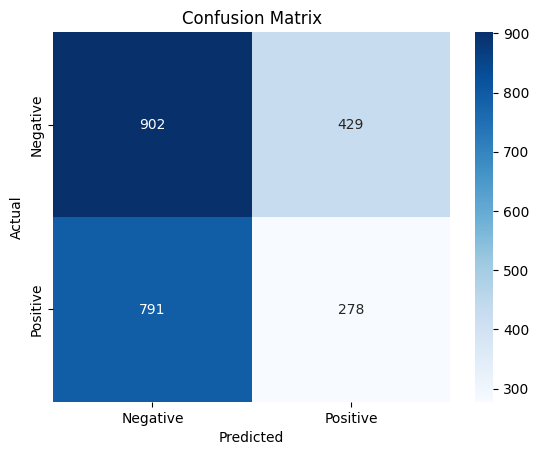

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


Best Parameters: {'C': 0.1, 'class_weight': None, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.58      0.96      0.73      1331
           1       0.75      0.14      0.24      1069

    accuracy                           0.60      2400
   macro avg       0.67      0.55      0.48      2400
weighted avg       0.66      0.60      0.51      2400



In [ ]:
import joblib

# Save the trained model
joblib.dump(best_model, 'model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
 # Load your trained model and vectorizer
import joblib
model = joblib.load("/content/model.pkl")
vectorizer = joblib.load("/content/tfidf_vectorizer.pkl")

sentence1 = "She finished her homework before dinner."
sentence2 = "Rabit is eating snacks."

# Preprocess if needed (e.g., lowercase, remove punctuation, etc.)
def preprocess(text):
    return text.lower()

s1 = preprocess(sentence1)
s2 = preprocess(sentence2)

# Transform using the fitted TF-IDF vectorizer
v1 = vectorizer.transform([s1])
v2 = vectorizer.transform([s2])

# Combine vectors (e.g., concatenate)
X_test_pair = np.hstack((v1.toarray(), v2.toarray()))

# Predict
prediction = model.predict(X_test_pair)[0]

if prediction == 1:
    print(" Paraphrase Detected")
else:
    print(" Not a Paraphrase")


 Not a Paraphrase


In [ ]:
# Load your tuned model and TF-IDF vectorizer
import joblib
import numpy as np

best_model = joblib.load("/content/model.pkl")  # <--- Save and load the grid search best model
vectorizer = joblib.load("/content/tfidf_vectorizer.pkl")

# Input sentences
sentence1 = "All five events started the last day and concluded with the final on the first day ."
sentence2 = "All five events started on the last day and concluded with the final on the first day ."

# Preprocess if needed (e.g., lowercase)
def preprocess(text):
    return text.lower()

# Preprocess sentences
s1 = preprocess(sentence1)
s2 = preprocess(sentence2)

# Transform using the loaded TF-IDF vectorizer
v1 = vectorizer.transform([s1])
v2 = vectorizer.transform([s2])

# Combine vectors (concatenate horizontally)
X_test_pair = np.hstack((v1.toarray(), v2.toarray()))

# Predict using the tuned model
prediction = best_model.predict(X_test_pair)[0]

# Output
if prediction == 1:
    print("Paraphrase Detected")
else:
    print("Not a Paraphrase")


Not a Paraphrase


In [ ]:
 # Load your trained model and vectorizer
import joblib
model = joblib.load("/content/model.pkl")
vectorizer = joblib.load("/content/tfidf_vectorizer.pkl")

sentence1 = "Kala is sleeping in the class"
sentence2 = "Rabit is eating snacks."

# Preprocess if needed (e.g., lowercase, remove punctuation, etc.)
def preprocess(text):
    return text.lower()

s1 = preprocess(sentence1)
s2 = preprocess(sentence2)

# Transform using the fitted TF-IDF vectorizer
v1 = vectorizer.transform([s1])
v2 = vectorizer.transform([s2])

# Combine vectors (e.g., concatenate)
X_test_pair = np.hstack((v1.toarray(), v2.toarray()))

# Predict
prediction = model.predict(X_test_pair)[0]

if prediction == 1:
    print(" Paraphrase Detected")
else:
    print(" Not a Paraphrase")


 Not a Paraphrase


In [ ]:
 # Load your trained model and vectorizer
import joblib
model = joblib.load("/content/model.pkl")
vectorizer = joblib.load("/content/tfidf_vectorizer.pkl")

sentence1 = "It is situated south of Köroğlu Mountains and to the north of Bolu ."
sentence2 = "It is situated south of Köroğlu - mountains and north of the Bolu ."

# Preprocess if needed (e.g., lowercase, remove punctuation, etc.)
def preprocess(text):
    return text.lower()

s1 = preprocess(sentence1)
s2 = preprocess(sentence2)

# Transform using the fitted TF-IDF vectorizer
v1 = vectorizer.transform([s1])
v2 = vectorizer.transform([s2])

# Combine vectors (e.g., concatenate)
X_test_pair = np.hstack((v1.toarray(), v2.toarray()))

# Predict
prediction = model.predict(X_test_pair)[0]

if prediction == 1:
    print(" Paraphrase Detected")
else:
    print(" Not a Paraphrase")


 Not a Paraphrase
